In [1]:
import Random#, logging
using  Plots, CSV, Gen#, Dates
using DataFrames: DataFrame
# Disable logging, because @animate is verbose otherwise
#Logging.disable_logging(Logging.Info);


(process:16484): GLib-GIO-WARNING **: 10:35:36.578: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.1900.3.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs


In [43]:
SubChunkSize = 20
@gen function regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    Indx = 1
    Buffer_x = 0
    Buffer_y = 0
    mu = 0
    prob_outlier = {:prob_outlier} ~ uniform(0, .2)
    for i = 1:NumChunks
        slope = {(:slope, i)} ~ normal(0, 3000)
        noise = {(:noise, i)} ~ gamma(200, 200)
        # Next, we generate the actual y coordinates.
         ys = Float64[]
        for j = 1:SubChunkSize
            # Decide whether this point is an outlier, and set
            # mean and standard deviation accordingly
            if(!(Indx > n))
                if ({:data => Indx => :is_outlier} ~ bernoulli(prob_outlier))
                    (mu, std) = (1000*(xs[Indx] - Buffer_x) * slope + Buffer_y,  100*noise)
                else
                    (mu, std) = ((xs[Indx] - Buffer_x) * slope + Buffer_y,  noise)
                end
                # Sample a y value for this point
                push!(ys, {:data => Indx => :y} ~ normal(mu, std))
                Indx += 1
            end
        end
        Buffer_y = mu
        Buffer_x = xs[Indx-1]
    end 
    ys
end;

In [29]:
using Plots
#length(floor(xs/40)+1)
function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    #print(xs)
    Dict(:slope => [trace[(:slope, i)] for i in 1:NumChunks],
         :inlier_std => [trace[(:noise, i)] for i in 1:NumChunks],
         :points => zip(xs, [trace[:data => i => :y] for i in 1:length(xs)]),
         :xs => xs,
         :outliers => [trace[:data => i => :is_outlier] for i in 1:length(xs)])
end

serialize_trace (generic function with 1 method)

In [50]:
function visualize_trace(trace::Trace; title="")
    trace = serialize_trace(trace)
    n = length(trace[:xs])
    NumChunks = div(n, SubChunkSize, RoundUp)
    outliers = [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if outlier]
    inliers =  [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if !outlier]
    PLT = Plots.scatter(map(first, inliers), map(last, inliers), markercolor="blue", label=nothing, title=title) 
    PLT = Plots.scatter!(map(first, outliers), map(last, outliers), markercolor="red", label=nothing)
    Buffer_y = 0
    Buffer_x = 0
    for i = 1:NumChunks
        inferred_line(x) = trace[:slope][i] * (x - Buffer_x) + Buffer_y
        if(1 + (i-1)*SubChunkSize > n)
            left_x = trace[:xs][n]
        else
            left_x = trace[:xs][1 + (i-1)*SubChunkSize]
        end
        left_y  = inferred_line(left_x)
        if(SubChunkSize*i > n)
            right_x = trace[:xs][n]
        else
            right_x = trace[:xs][SubChunkSize*i]
        end
        right_y = inferred_line(right_x)
        PLT = Plots.plot!([left_x, right_x], [left_y, right_y], color = "black", lw = 3, label = nothing)
        Buffer_y = right_y
        Buffer_x = right_x
    end
    return PLT
end
#, xlims=[MinX, MaxX], ylims=[MinY, MaxY]

visualize_trace (generic function with 1 method)

In [5]:
dataframe = CSV.read("../Data/Proccesed/DetrendedCov.csv", DataFrame)

,Column1,Date,N1,LoessN1,DetrendedN1
,Int64,Int64,Int64,Float64,Float64
1,1,0,63618,-3628.0,67246.0
2,2,4,11442,12206.4,-764.409
3,3,7,39145,24029.8,15115.2
4,4,10,28553,35819.2,-7266.18
5,5,9,16743,31895.1,-15152.1
6,6,8,30509,27971.0,2538.04
7,7,13,22794,47527.4,-24733.4
8,8,14,25014,51430.1,-26416.1
9,9,17,38687,63050.0,-24363.0


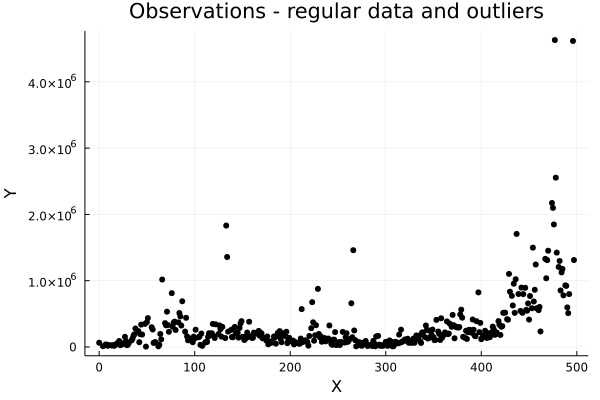

In [58]:
#using DataArrays
dataframe[!,:N1] = convert.(Base.Float64,dataframe[!,:N1])
dataframe[!,:Date] = convert.(Base.Float64,dataframe[!,:Date])

xs = dataframe."Date"[1:390]
ys = dataframe."N1"[1:390]

Plots.scatter(xs, ys, color="black", xlabel="X", ylabel="Y", 
              label=nothing, title="Observations - regular data and outliers")

In [45]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

In [46]:
observations = make_constraints(ys);

In [9]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

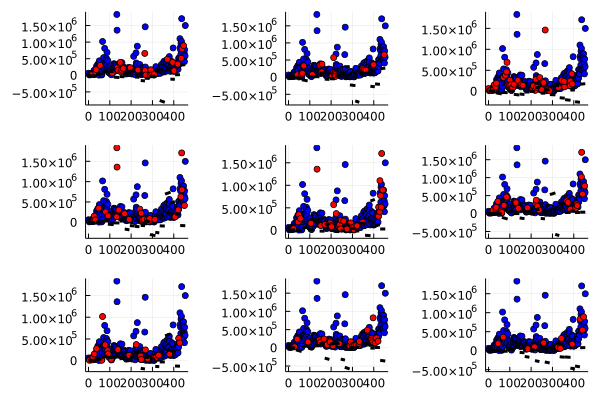

In [10]:
traces    = [first(Gen.importance_resampling(regression_with_outliers, (xs,), observations, 1000)) for i in 1:9]
#log_probs = [get_score(t) for t in traces]
#println("Average log probability: $(logmeanexp(log_probs))")
Plots.plot([visualize_trace(t) for t in traces]...)

In [59]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    (xs,) = get_args(tr)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    for j=1:NumChunks
        # Block 1: Update the line's parameters
        line_params = select((:noise,j), (:slope,j), (:intercept,j))
        (tr, _) = mh(tr, line_params)
    end
    
    # Blocks 2-N+1: Update the outlier classifications
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

In [48]:
function block_resimulation_inference(xs, ys)
    observations = make_constraints(ys)
    (tr, W) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:100
        tr = block_resimulation_update(tr)
    end
    tr
end;

In [12]:
scores = Vector{Float64}(undef, 3)
for i=1:3
    @time tr = block_resimulation_inference(xs, ys)
    scores[i] = get_score(tr)
end;
println("Log probability: ", logmeanexp(scores))

 83.712637 seconds (661.21 M allocations: 36.542 GiB, 10.38% gc time, 2.20% compilation time)
 89.598395 seconds (658.17 M allocations: 36.377 GiB, 10.42% gc time)
 80.416464 seconds (658.17 M allocations: 36.377 GiB, 10.16% gc time)
Log probability: -5577.853642078491


In [14]:
scores = Vector{Float64}(undef, 3)
for i=1:3
    @time (tr, W) = importance_resampling(regression_with_outliers, (xs,), observations, 170)
    scores[i] = get_score(tr)
end;
println("Log probability: ", logmeanexp(scores))

 20.904954 seconds (231.35 M allocations: 15.110 GiB, 12.68% gc time)
 20.838483 seconds (231.35 M allocations: 15.110 GiB, 12.84% gc time)
 20.915417 seconds (231.35 M allocations: 15.110 GiB, 12.73% gc time)
Log probability: -646493.40953283


In [61]:
t, = generate(regression_with_outliers, (xs,), observations)

viz = Plots.@animate for i in 1:300
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/300")
end;
gif(viz)

┌ Info: Saved animation to 
│   fn = C:\Users\marli\AppData\Local\Temp\jl_PEwjKMFCSv.gif
└ @ Plots C:\Users\marli\.julia\packages\Plots\tXtrW\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\marli\\AppData\\Local\\Temp\\jl_PEwjKMFCSv.gif")
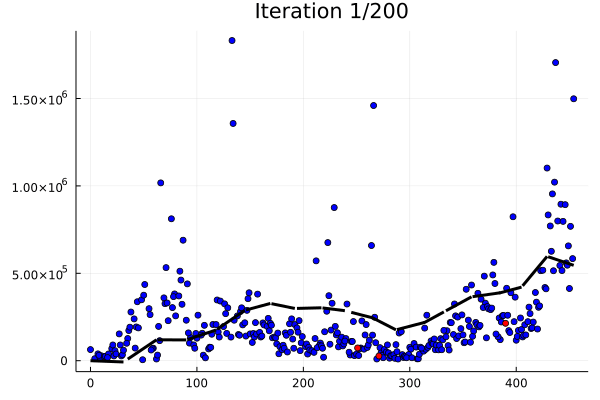

In [18]:
t, = generate(regression_with_outliers, (xs,), observations)

viz = Plots.@animate for i in 1:200
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/200")
end;
gif(viz)